In [2]:
import os 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from scipy import stats

# Set some options...
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

cwd = os.getcwd()

for dirname, _, filenames in os.walk(f'{cwd}/data'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

/Users/davitdadiani/Desktop/git/ml-walmart-recruiting/data/lightgbm_submission.csv
/Users/davitdadiani/Desktop/git/ml-walmart-recruiting/data/train_merged.csv
/Users/davitdadiani/Desktop/git/ml-walmart-recruiting/data/test_merged.csv
/Users/davitdadiani/Desktop/git/ml-walmart-recruiting/data/sampleSubmission.csv
/Users/davitdadiani/Desktop/git/ml-walmart-recruiting/data/test.csv
/Users/davitdadiani/Desktop/git/ml-walmart-recruiting/data/train.csv
/Users/davitdadiani/Desktop/git/ml-walmart-recruiting/data/features.csv
/Users/davitdadiani/Desktop/git/ml-walmart-recruiting/data/stores.csv


In [3]:
train = pd.read_csv(f"{cwd}/data/train.csv", parse_dates=["Date"])
test = pd.read_csv(f"{cwd}/data/test.csv", parse_dates=["Date"])
features = pd.read_csv(f"{cwd}/data/features.csv", parse_dates=["Date"])
stores = pd.read_csv(f"{cwd}/data/stores.csv")

In [4]:
train_merged = train.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
train_merged = train_merged.merge(stores, on="Store", how="left")

test_merged = test.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
test_merged = test_merged.merge(stores, on="Store", how="left")

# Some usefull functions 

In [5]:
def plot_univariate(df, feature, bins=20):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], bins=bins, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

def plot_bivariate(df, feature1, feature2):
    plt.figure(figsize=(10, 6))
    if df[feature1].dtype in ['float64', 'int64'] and df[feature2].dtype in ['float64', 'int64']:
        sns.scatterplot(x=df[feature1], y=df[feature2])
        plt.title(f'Relationship between {feature1} and {feature2}')
        plt.xlabel(feature1)
        plt.ylabel(feature2)
    else:
        sns.boxplot(x=df[feature1], y=df[feature2])
        plt.title(f'Box plot of {feature2} by {feature1}')
        plt.xlabel(feature1)
        plt.ylabel(feature2)
    
    plt.show()

def plot_countplot(df, feature1, feature2=None):
    plt.figure(figsize=(12, 6))
    
    if feature2:
        sns.countplot(data=df, x=feature1, hue=feature2)
        plt.title(f'Count of {feature1} segmented by {feature2}')
        plt.xlabel(feature1)
        plt.ylabel('Count')
        plt.legend(title=feature2)
    else:
        sns.countplot(data=df, x=feature1)
        plt.title(f'Count of {feature1}')
        plt.xlabel(feature1)
        plt.ylabel('Count')

    plt.show()

def get_num_and_cat_features(df):
    num = [feature for feature in df.columns if df[feature].dtype != 'object']
    cat = [feature for feature in df.columns if df[feature].dtype == 'object']
  
    return (num, cat)

def get_numerical_features(df):
    return get_num_and_cat_features(df)[0]

def get_categorical_features(df):
    return get_num_and_cat_features(df)[1]

def print_null_count(df, head=None):
    null_summary = df.isnull().sum()
    null_summary = null_summary[null_summary > 0].sort_values(ascending=False)
    if head != None:
        null_summary = null_summary.head(head)

    print(f"{'Feature':<20} {'Null Count':<12} {'Null %':<10}")
    print("-" * 45)

    for feature, null_count in null_summary.items():
        null_percentage = null_count / len(df)
        print(f"{feature:<20} {null_count:<12} {null_percentage:<10.5f}")

# Inspect Dataframes

In [6]:
print("Train merged shape: ", train_merged.shape)
print("Train merged shape: ", test_merged.shape)

Train merged shape:  (421570, 16)
Train merged shape:  (115064, 15)


In [7]:
train_merged.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [8]:
test_merged.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315


In [9]:
print_null_count(train_merged)

Feature              Null Count   Null %    
---------------------------------------------
MarkDown2            310322       0.73611   
MarkDown4            286603       0.67985   
MarkDown3            284479       0.67481   
MarkDown1            270889       0.64257   
MarkDown5            270138       0.64079   


In [10]:
print_null_count(test_merged)

Feature              Null Count   Null %    
---------------------------------------------
CPI                  38162        0.33166   
Unemployment         38162        0.33166   
MarkDown2            28627        0.24879   
MarkDown4            12888        0.11201   
MarkDown3            9829         0.08542   
MarkDown1            149          0.00129   


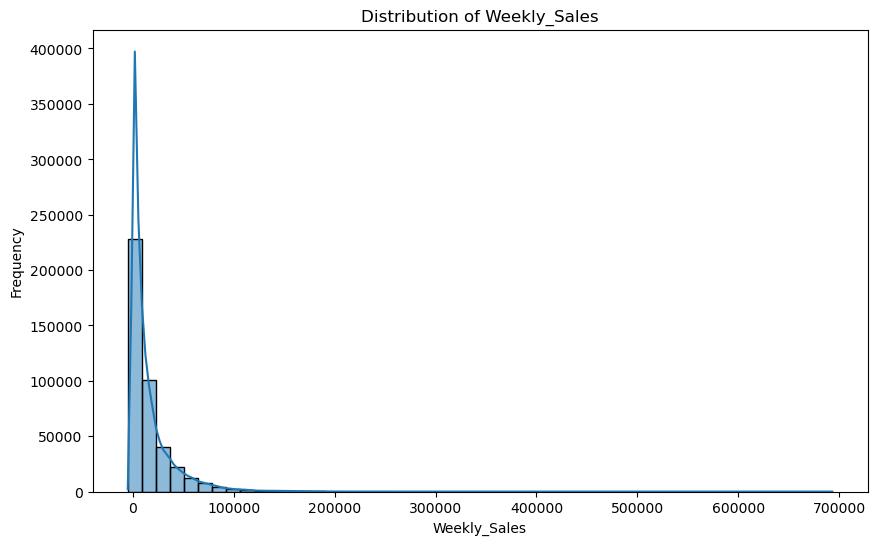

In [11]:
plot_univariate(train_merged, "Weekly_Sales", bins=50)

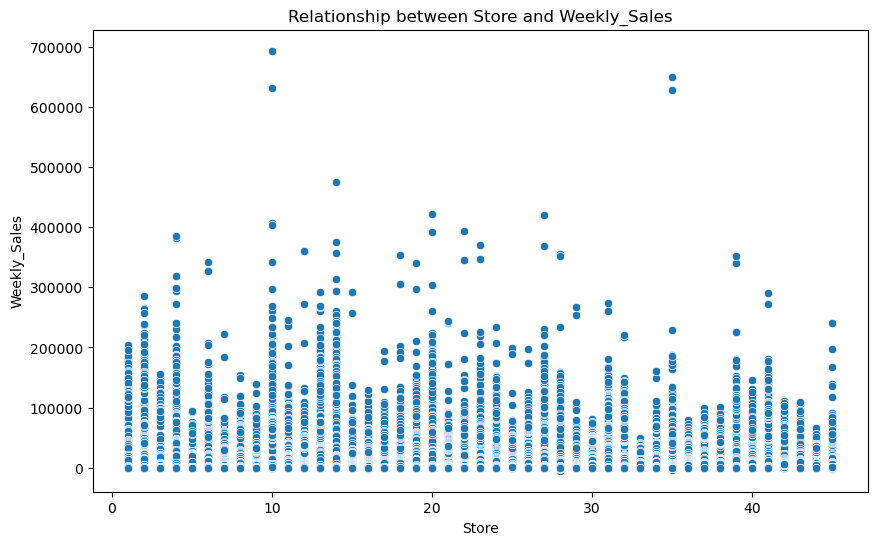

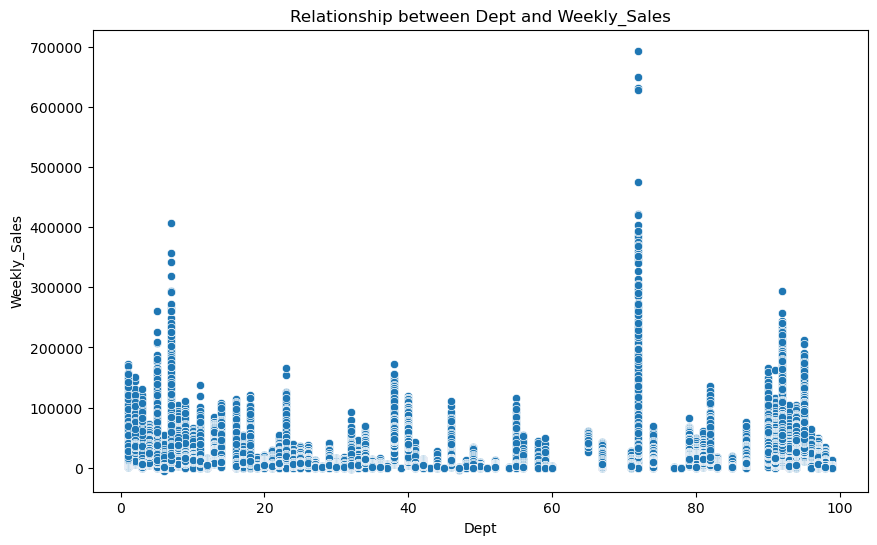

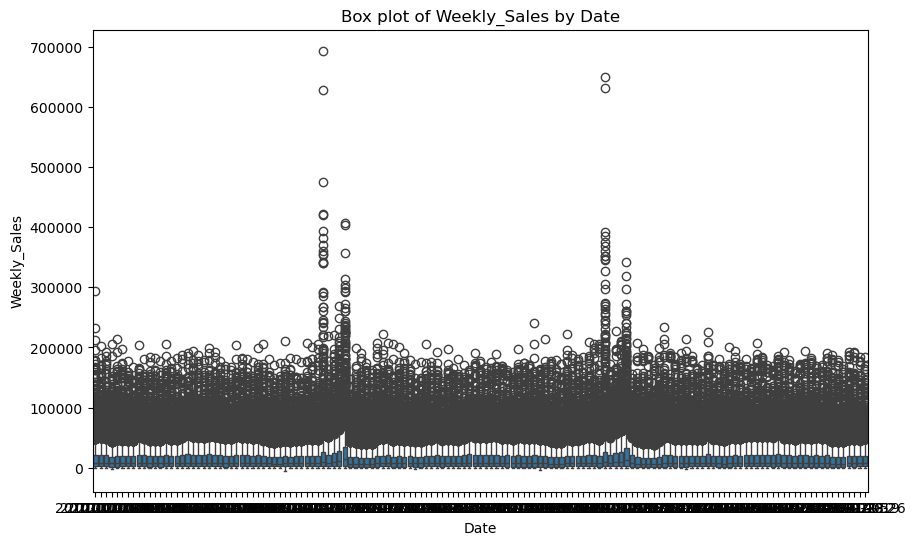

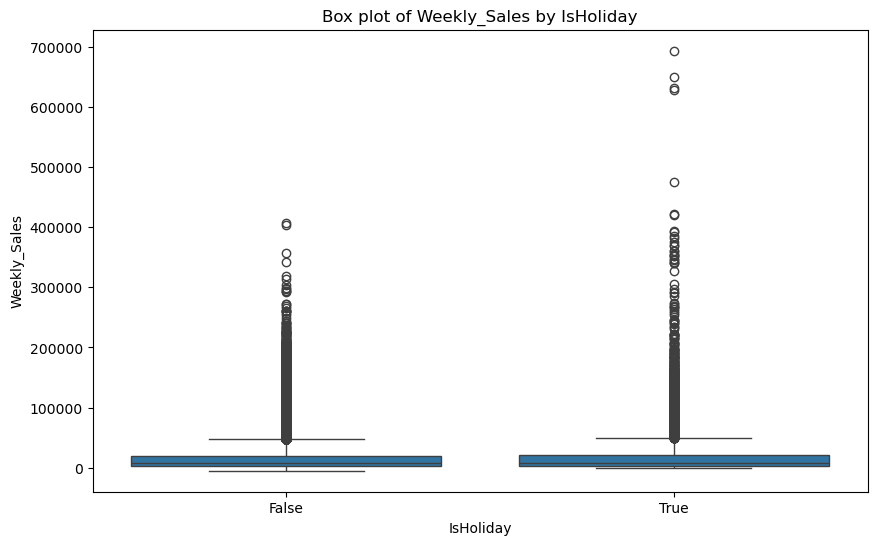

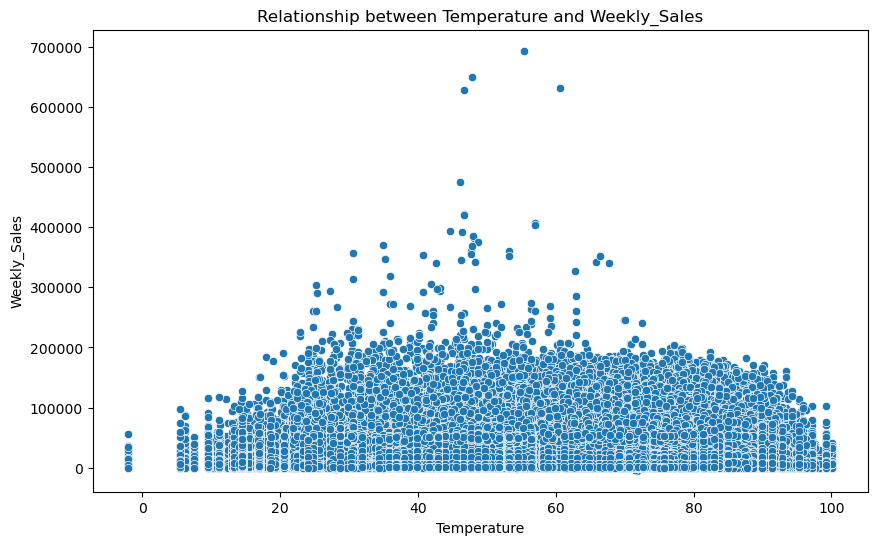

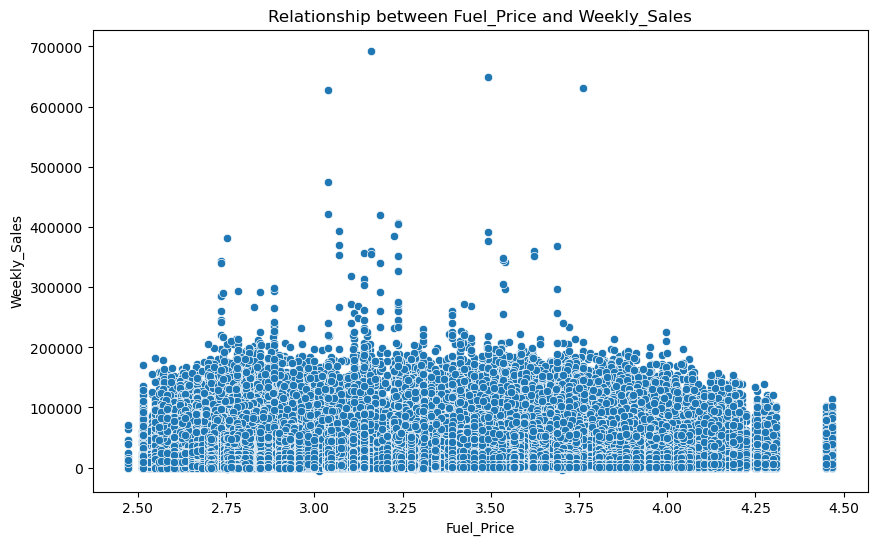

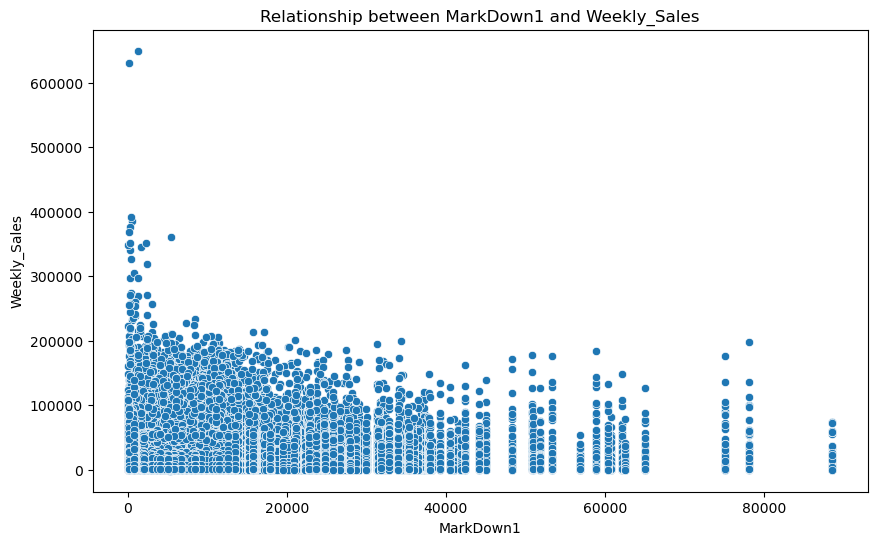

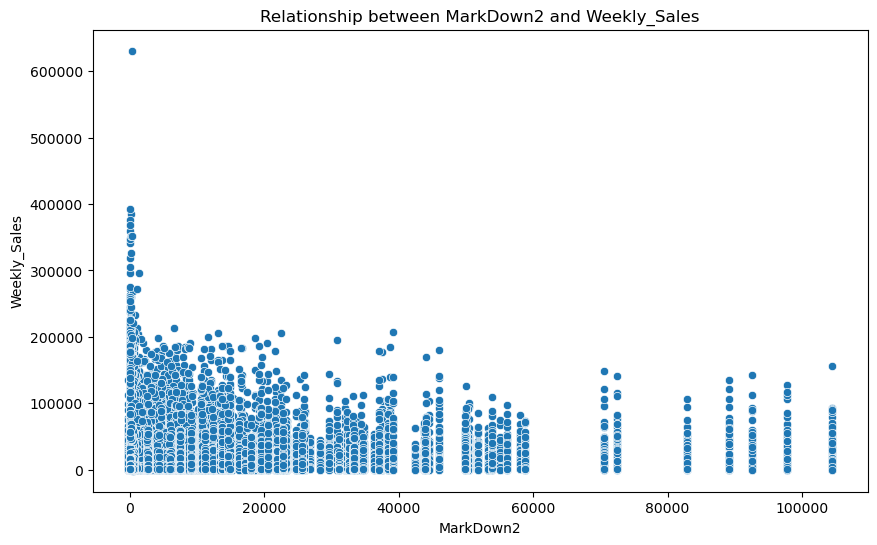

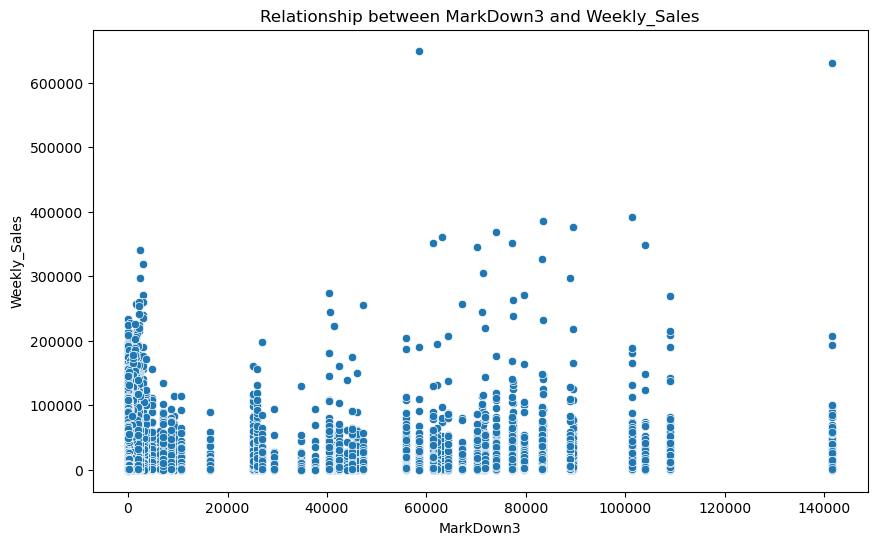

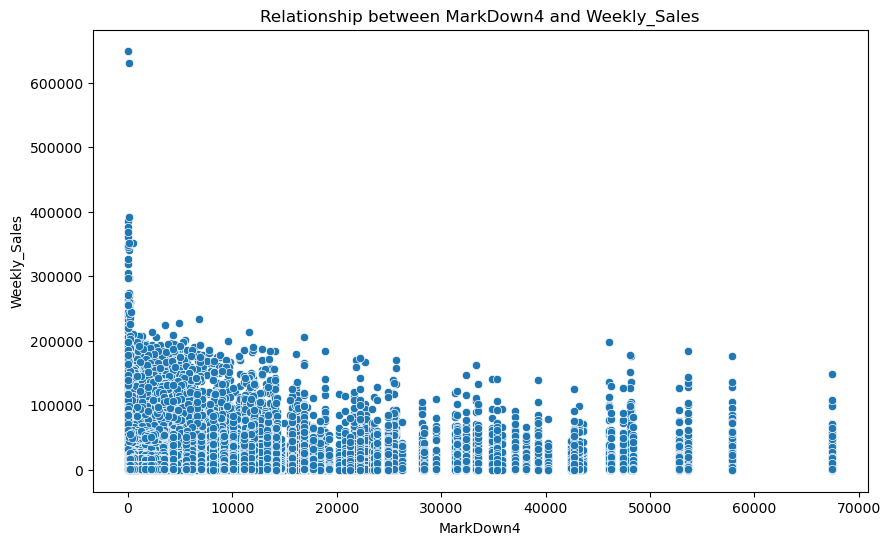

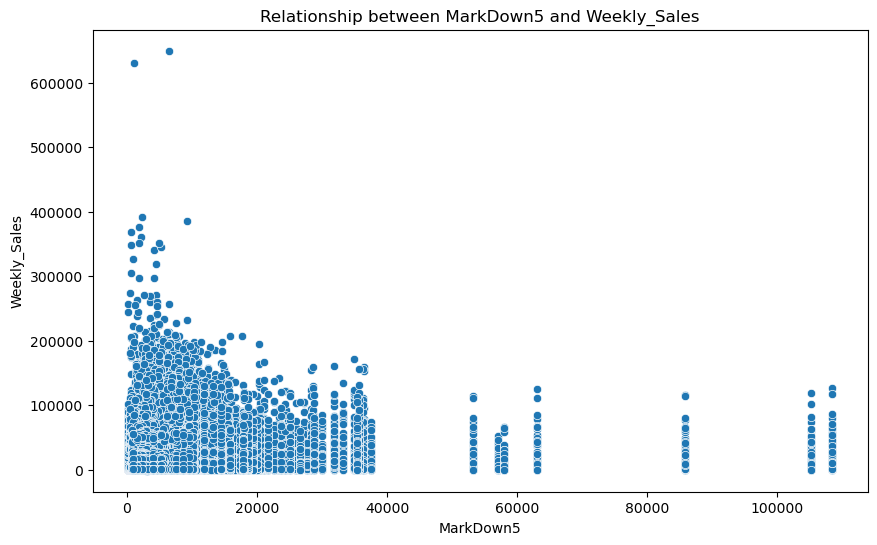

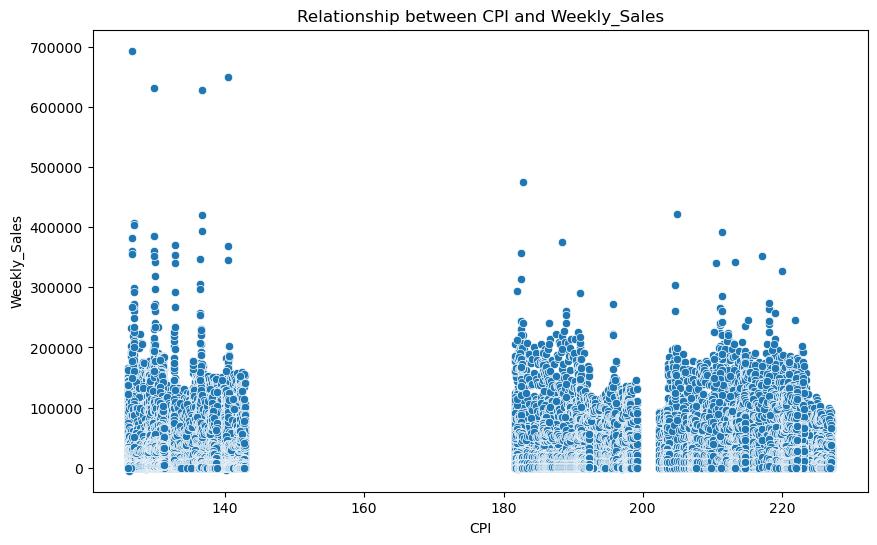

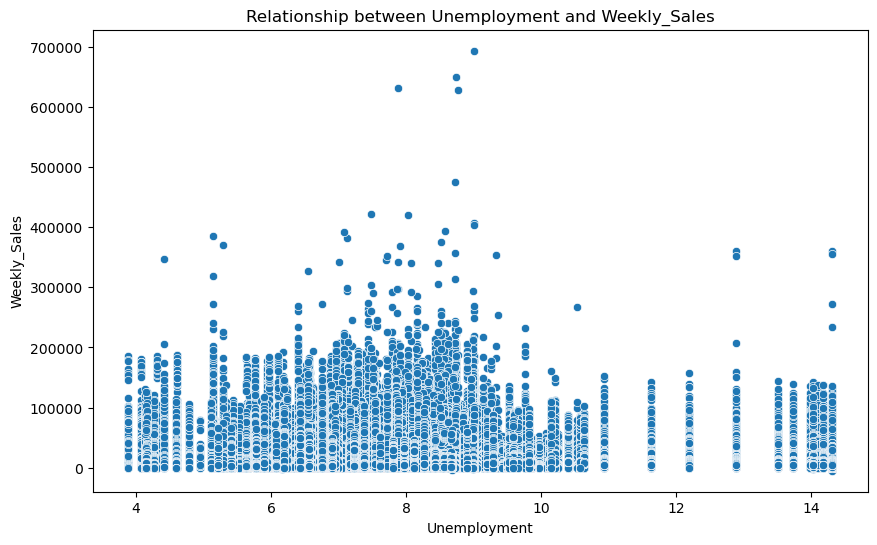

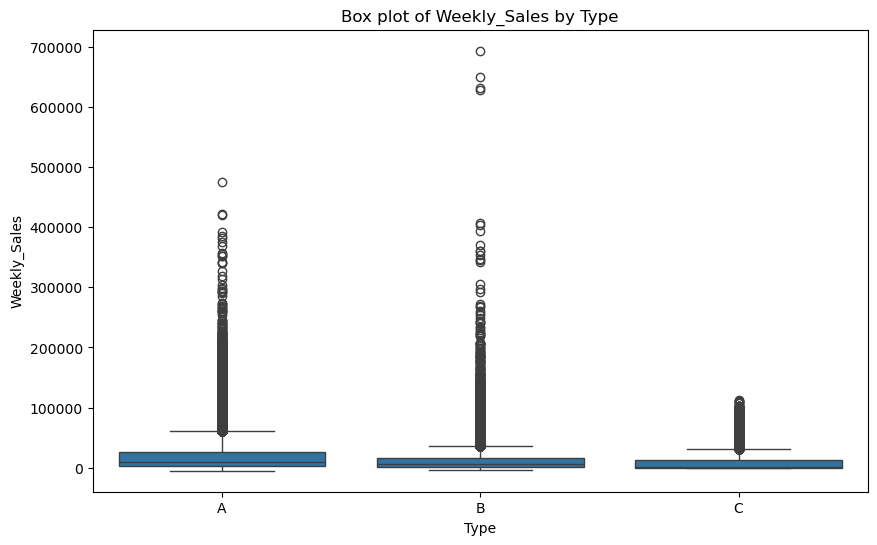

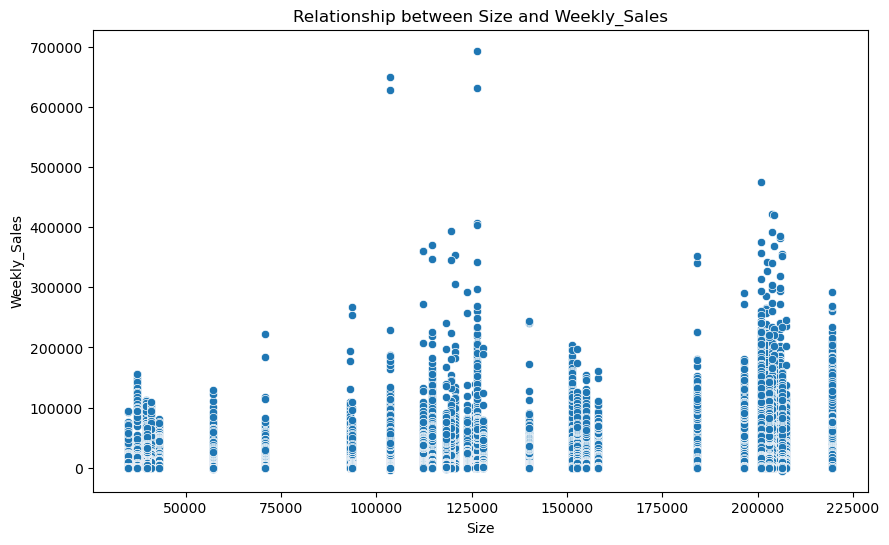

In [12]:
target = "Weekly_Sales"

for feature in train_merged.columns:
    if feature != target:
        plot_bivariate(train_merged, feature, target)

In [13]:
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    train_merged[col] = train_merged[col].fillna(0)
    test_merged[col] = test_merged[col].fillna(0)

In [14]:
for col in ['CPI', 'Unemployment']:
    test_merged[col] = test_merged.groupby('Store')[col].transform(lambda x: x.ffill().bfill())

In [15]:
print_null_count(train_merged)

Feature              Null Count   Null %    
---------------------------------------------


In [16]:
print_null_count(test_merged)

Feature              Null Count   Null %    
---------------------------------------------


In [17]:
train_merged.to_csv(f"{cwd}/data/train_merged.csv", index=False)
test_merged.to_csv(f"{cwd}/data/test_merged.csv", index=False)